# 1. Load Data & Data Cleaning

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [6]:
transcript['viewed_id'] =  transcript.apply(lambda x:x['value']['offer id'] if x['event']=='offer viewed' else np.nan,axis=1)

In [7]:
transcript['amount'] =  transcript.apply(lambda x:x['value']['amount'] if x['event']=='transaction' else np.nan,axis=1)

In [8]:
transcript['received_id'] = transcript.apply(lambda x:x['value']['offer id'] if x['event']=='offer received' else np.nan,axis=1)

In [9]:
transcript['completed_id'] = transcript.apply(lambda x:x['value']['offer_id'] if x['event']=='offer completed' else np.nan,axis=1)

In [10]:
transcript.head()

,person,event,value,time,viewed_id,amount,received_id,completed_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [76]:
 def clean_transcript(df):
    people_list = df.person.drop_duplicates().tolist()
    result = pd.DataFrame(columns=['person','offer_completed','id','amount'])
    
    for person in people_list:
        person_data = df[df.person == person]
        received_df = person_data[~person_data.received_id.isna()]
        completed_df = person_data[~person_data.completed_id.isna()]
        offer_ids = received_df.received_id.drop_duplicates().tolist()
        completed_ids = completed_df.completed_id.drop_duplicates().tolist()
        transaction_df = person_data[person_data.event=='transaction']
        for offer in offer_ids:
            if offer in completed_ids:
                offer_completed=1
                time = completed_df[completed_df.completed_id == offer]['time'].values[0]
                amount = transaction_df[transaction_df.time==time]['amount'].max()
            else:
                offer_completed = 0
                amount = np.nan
            temp_df = pd.DataFrame({'person':person,'offer_completed':offer_completed,'id':offer,'amount':amount},index=[0])
            result = result.append(temp_df,ignore_index=True)
        # calculate the rate of transaction with "none" offer
        #transaction_df = person_data[person_data.event=='transaction']
        transaction_time = transaction_df.time.tolist()
        #transaction_with_offer = 0
        for tran_time in transaction_time:
            time_df = person_data[person_data.time == tran_time]
            event =  time_df.event.tolist()
            if 'offer completed' not in event:
                transaction_with_offer = 1
                amount = transaction_df[transaction_df.time==tran_time].amount.max()
                temp_df = pd.DataFrame({'person':person,'offer_completed':transaction_with_offer,'id':'none','amount':amount},index=[0])
                result = result.append(temp_df,ignore_index=True)
        
    return result
            
                
    
    

In [77]:
transcript.person.drop_duplicates()

0         78afa995795e4d85b5d9ceeca43f5fef
1         a03223e636434f42ac4c3df47e8bac43
2         e2127556f4f64592b11af22de27a7932
3         8ec6ce2a7e7949b1bf142def7d0e0586
4         68617ca6246f4fbc85e91a2a49552598
                        ...               
213585    9fcbff4f8d7241faa4ab8a9d19c8a812
222411    ebae5093b436466c9fbd097cb7434023
249251    912b9f623b9e4b4eb99b6dc919f09a93
253904    3045af4e98794a04a5542d3eac939b1f
263150    da7a7c0dcfcb41a8acc7864a53cf60fb
Name: person, Length: 17000, dtype: object

In [79]:
clean_transcript(transcript)

,person,offer_completed,id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,19.89
1,78afa995795e4d85b5d9ceeca43f5fef,0,5a8bc65990b245e5a138643cd4eb9837,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,1,ae264e3637204a6fb9bb56bc8210ddfd,21.72
3,78afa995795e4d85b5d9ceeca43f5fef,1,f19421c1d4aa40978ebb69ca19b0e20d,21.72
4,78afa995795e4d85b5d9ceeca43f5fef,1,none,17.78
5,78afa995795e4d85b5d9ceeca43f5fef,1,none,19.67
6,78afa995795e4d85b5d9ceeca43f5fef,1,none,29.72
7,78afa995795e4d85b5d9ceeca43f5fef,1,none,23.93
8,78afa995795e4d85b5d9ceeca43f5fef,1,none,26.56
9,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [80]:
cleaned_data = _

In [12]:
cleaned_data.head()

,Unnamed: 0,person,offer_completed,id,amount
0,0,78afa995795e4d85b5d9ceeca43f5fef,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,19.89
1,1,78afa995795e4d85b5d9ceeca43f5fef,0,5a8bc65990b245e5a138643cd4eb9837,NaN
2,2,78afa995795e4d85b5d9ceeca43f5fef,1,ae264e3637204a6fb9bb56bc8210ddfd,21.72
3,3,78afa995795e4d85b5d9ceeca43f5fef,1,f19421c1d4aa40978ebb69ca19b0e20d,21.72
4,4,78afa995795e4d85b5d9ceeca43f5fef,1,none,17.78


In [13]:
profile = profile.rename(columns={'id':'person'})

In [14]:
cleaned_data.head()

,Unnamed: 0,person,offer_completed,id,amount
0,0,78afa995795e4d85b5d9ceeca43f5fef,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,19.89
1,1,78afa995795e4d85b5d9ceeca43f5fef,0,5a8bc65990b245e5a138643cd4eb9837,NaN
2,2,78afa995795e4d85b5d9ceeca43f5fef,1,ae264e3637204a6fb9bb56bc8210ddfd,21.72
3,3,78afa995795e4d85b5d9ceeca43f5fef,1,f19421c1d4aa40978ebb69ca19b0e20d,21.72
4,4,78afa995795e4d85b5d9ceeca43f5fef,1,none,17.78


In [15]:
data = pd.merge(cleaned_data,profile,how='inner',on='person')

In [16]:
data.shape

(171624, 9)

In [17]:
data = pd.merge(data,portfolio,how='outer',on='id')

In [18]:
data['offer_type'] = data.offer_type.fillna('none')

In [19]:
data[data.id=='none']

,Unnamed: 0,person,offer_completed,id,amount,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
25311,4,78afa995795e4d85b5d9ceeca43f5fef,1,none,17.78,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,none
25312,5,78afa995795e4d85b5d9ceeca43f5fef,1,none,19.67,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,none
25313,6,78afa995795e4d85b5d9ceeca43f5fef,1,none,29.72,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,none
25314,7,78afa995795e4d85b5d9ceeca43f5fef,1,none,23.93,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,none
25315,8,78afa995795e4d85b5d9ceeca43f5fef,1,none,26.56,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133642,171612,3873fe915496482eb589fa316ae7b0db,1,none,1.21,M,58,20170905,57000.0,NaN,NaN,NaN,NaN,none
133643,171613,3873fe915496482eb589fa316ae7b0db,1,none,2.65,M,58,20170905,57000.0,NaN,NaN,NaN,NaN,none
133644,171616,8578196a074a4f328976e334fa9383a3,1,none,4.62,M,48,20180610,58000.0,NaN,NaN,NaN,NaN,none
133645,171620,ebae5093b436466c9fbd097cb7434023,1,none,2.57,None,118,20171203,NaN,NaN,NaN,NaN,NaN,none


In [20]:
def transfer_channels(x,tag):
    if type(x)==list:
        if tag in x:
            return 1
        else:
            return 0
    else:
        return np.nan

In [21]:
# transfer channels into dummy variables
for tag in ['web', 'email', 'mobile', 'social']:
    data[tag] = data['channels'].apply(lambda x: transfer_channels(x,tag))

In [22]:
data.shape

(171624, 18)

# 2. Data Preprocessing & Model Tuning

## 2.1 Data Preprocessing

In [23]:
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
from sklearn.metrics import f1_score
#from sklearn.
#from xgboost import XGBClassifier

In [24]:
import datetime
def calculate_time(x):
    try:
        x = str(int(x))
        x_ts = datetime.datetime.strptime(x,'%Y%m%d')
        time_delta = datetime.datetime.now()-x_ts
        return time_delta.days
    except:
        return np.nan

In [25]:
data['member_duration'] = data.became_member_on.apply(lambda x:calculate_time(x))

In [26]:
def transfer_gender_variables(x):
    if x=='F':
        return 1
    elif x =='M':
        return -1
    else:
        return 0
data['gender'] = data['gender'].apply(lambda x:transfer_gender_variables(x))

In [27]:
for col in ['reward','difficulty','duration','web','email','mobile','social','amount']:
    data[col] = data[col].fillna(0.0)

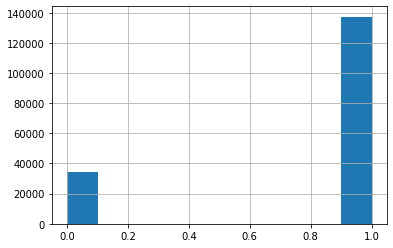

In [28]:
data.offer_completed.hist()

In [29]:
data_input = data.dropna(subset=[ 'gender',
       'age',  'member_duration', 'income','reward','duration','difficulty'])

In [30]:
del data_input['channels']

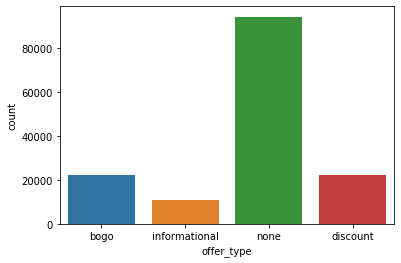

In [31]:
import seaborn as sns
sns.countplot(x='offer_type', data=data_input)

In [32]:
data_input.head()

,Unnamed: 0,person,offer_completed,id,amount,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,web,email,mobile,social,member_duration
0,0,78afa995795e4d85b5d9ceeca43f5fef,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,19.89,1,75,20170509,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,1262
1,17,e2127556f4f64592b11af22de27a7932,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,18.42,-1,68,20180426,70000.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,910
3,33,389bc3fa690240e798340f5a15918d5c,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,15.63,-1,65,20180209,53000.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,986
4,127,d058f73bf8674a26a95227db098147b1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,1,56,20180428,88000.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,908
6,149,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,-1,59,20150121,41000.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,2101


In [33]:
data_input.columns

Index(['Unnamed: 0', 'person', 'offer_completed', 'id', 'amount', 'gender',
       'age', 'became_member_on', 'income', 'reward', 'difficulty', 'duration',
       'offer_type', 'web', 'email', 'mobile', 'social', 'member_duration'],
      dtype='object')

In [34]:
data_input[data_input.offer_type=='none']

,Unnamed: 0,person,offer_completed,id,amount,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,web,email,mobile,social,member_duration
25311,4,78afa995795e4d85b5d9ceeca43f5fef,1,none,17.78,1,75,20170509,100000.0,0.0,0.0,0.0,none,0.0,0.0,0.0,0.0,1262
25312,5,78afa995795e4d85b5d9ceeca43f5fef,1,none,19.67,1,75,20170509,100000.0,0.0,0.0,0.0,none,0.0,0.0,0.0,0.0,1262
25313,6,78afa995795e4d85b5d9ceeca43f5fef,1,none,29.72,1,75,20170509,100000.0,0.0,0.0,0.0,none,0.0,0.0,0.0,0.0,1262
25314,7,78afa995795e4d85b5d9ceeca43f5fef,1,none,23.93,1,75,20170509,100000.0,0.0,0.0,0.0,none,0.0,0.0,0.0,0.0,1262
25315,8,78afa995795e4d85b5d9ceeca43f5fef,1,none,26.56,1,75,20170509,100000.0,0.0,0.0,0.0,none,0.0,0.0,0.0,0.0,1262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133640,171608,47683732768a4f7db7abb710ca22e66e,1,none,7.10,-1,24,20171108,56000.0,0.0,0.0,0.0,none,0.0,0.0,0.0,0.0,1079
133641,171611,3873fe915496482eb589fa316ae7b0db,1,none,1.57,-1,58,20170905,57000.0,0.0,0.0,0.0,none,0.0,0.0,0.0,0.0,1143
133642,171612,3873fe915496482eb589fa316ae7b0db,1,none,1.21,-1,58,20170905,57000.0,0.0,0.0,0.0,none,0.0,0.0,0.0,0.0,1143
133643,171613,3873fe915496482eb589fa316ae7b0db,1,none,2.65,-1,58,20170905,57000.0,0.0,0.0,0.0,none,0.0,0.0,0.0,0.0,1143


In [35]:
data_input.to_csv('data_input.csv')

In [36]:
data_input = shuffle(data_input)
X_col = ['gender','age', 'member_duration', 'income','reward','difficulty']
data_X = data_input.loc[:,X_col]
normalized_x = normalize(data_X)
data_y = data_input.loc[:,'offer_completed']
x_train, x_test, y_train, y_test = train_test_split(normalized_x, data_y.values, test_size=0.25, random_state=1)

In [37]:
model_result = pd.DataFrame(columns = ['model_parameter','accuracy','f1-score','precision',
                                      'test_accuracy','test_f1-score','test_precision'])

## 2.2 Benchmark Model : Decision Tree

In [48]:
def calculate_model_score(model):
    model_name = model.__class__.__name__
    model_result.loc[model_name,'model_parameter'] = str(model.get_params())
    accuracy = cross_val_score(model, x_train, y_train, cv = 10)
    accuracy_mean = np.mean(accuracy)
    model_result.loc[model_name,'accuracy'] = accuracy_mean
    f1_score_array = cross_val_score(model, x_train, y_train, scoring='f1', cv = 10)
    f1_score_mean = np.mean(f1_score_array)
    model_result.loc[model_name,'f1-score'] = f1_score_mean
    precision = cross_val_score(model, x_train, y_train, scoring='precision', cv = 10)
    precision = np.mean(precision)
    model_result.loc[model_name,'precision'] = precision
    test_y_predicted = model.predict(x_test)
    test_accuracy = accuracy_score(y_test,test_y_predicted)
    test_precision = precision_score(y_test,test_y_predicted)
    test_f1 = f1_score(y_test,test_y_predicted)
    model_result.loc[model_name,'test_accuracy'] = test_accuracy
    model_result.loc[model_name,'test_f1-score'] = test_f1
    model_result.loc[model_name,'test_precision'] = test_precision
    
    print('accuracy : %f' % accuracy_mean)
    print("f1-score : %f" % f1_score_mean)
    print('precision : %f' % precision)
    print("test_accuracy : %f" % test_accuracy)
    print("test_f1-score : %f" % test_f1)
    print("test_precision : %f" % test_precision)
 

In [49]:
decision_tree_model = DecisionTreeClassifier(random_state=0)
decision_tree_model.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [50]:
calculate_model_score(decision_tree_model)

accuracy : 0.798713
f1-score : 0.879556
precision : 0.861909
test_accuracy : 0.804626
test_f1-score : 0.883150
test_precision : 0.861614


## 2.2 Logistic Regression

In [51]:
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(x_train,y_train)
calculate_model_score(logistic_regression_model)

accuracy : 0.818491
f1-score : 0.900187
precision : 0.818491
test_accuracy : 0.815107
test_f1-score : 0.898137
test_precision : 0.815107


##  2.4 Random Forest

In [43]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [47]:
calculate_model_score(random_forest_model)

accuracy : 0.829819
f1-score : 0.900171
precision : 0.865451
test_accuracy : 0.830668
test_f1-score : 0.900476
test_precision : 0.864306


## 2.5 AdaBoosting

In [45]:
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [46]:
calculate_model_score(adaboost_model)

accuracy : 0.835318
f1-score : 0.906195
precision : 0.848861
test_accuracy : 0.832193
test_f1-score : 0.904195
test_precision : 0.845616


## 2.6 XGBoost

In [70]:
import boto3
import sagemaker
import os
from sagemaker import get_execution_role
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()
region = boto3.Session().region_name 
bucket = sagemaker_session.default_bucket()

In [71]:
data_dir = 'clean_data'

In [72]:
prefix = 'sagemaker/starbucks_capstone_xgboost'

In [73]:
data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

In [75]:
def upload_data(x,y,save_path):
    x_df = pd.DataFrame(x,columns=[i for i in range(1,x.shape[1]+1)])
    y_df = pd.DataFrame(y)
    train_df = pd.concat([y_df,x_df],axis=1)
    train_df.to_csv(save_path,header=False, index=False)

In [76]:
upload_data(x_train,y_train,'train.csv')

In [77]:
upload_data(x_test,y_test,'test.csv')

In [78]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train/'.format(bucket, prefix), content_type='text/csv')
s3_input_test = sagemaker.s3_input(s3_data='s3://{}/{}/test/'.format(bucket, prefix), content_type='text/csv')


's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [83]:
from sagemaker.amazon.amazon_estimator import get_image_uri

sess = sagemaker.Session()

container = get_image_uri(region, 'xgboost')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(max_depth=2,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100,
                        eval_metric='auc')

xgb.fit({'train': s3_input_train, 'validation': s3_input_test})

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-10-22 15:08:44 Starting - Starting the training job...
2020-10-22 15:08:47 Starting - Launching requested ML instances......
2020-10-22 15:09:45 Starting - Preparing the instances for training...
2020-10-22 15:10:43 Downloading - Downloading input data
2020-10-22 15:10:43 Training - Training image download completed. Training in progress..Arguments: train
[2020-10-22:15:10:44:INFO] Running standalone xgboost training.
[2020-10-22:15:10:44:INFO] File size need to be processed in the node: 15.0mb. Available memory size in the node: 8127.74mb
[2020-10-22:15:10:44:INFO] Determined delimiter of CSV input is ','
[15:10:44] S3DistributionType set as FullyReplicated
[15:10:44] 112198x6 matrix with 673188 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-10-22:15:10:44:INFO] Determined delimiter of CSV input is ','
[15:10:44] S3DistributionType set as FullyReplicated
[15:10:44] 37400x6 matrix with 224400 entries loaded from /opt/ml/input/data/validati

In [129]:
xgb.hyperparam_dict

{'max_depth': 2,
 'eta': 0.2,
 'gamma': 4,
 'min_child_weight': 6,
 'subsample': 0.8,
 'silent': 0,
 'objective': 'binary:logistic',
 'num_round': 100,
 'eval_metric': 'auc'}

In [86]:
predictors = xgb.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

In [98]:
from sagemaker.predictor import csv_serializer
xgb_predictor = sagemaker.predictor.RealTimePredictor(
"xgboost-2020-10-22-15-08-44-790", 
sagemaker_session=sagemaker_session,
serializer=csv_serializer,
content_type='text/csv')

In [119]:
predicted_y_train = [ float(xgb_predictor.predict(x).decode())>=0.5 for x in x_train ]

In [120]:
predicted_y_test = [float(xgb_predictor.predict(x).decode())>=0.5 for x in x_test]

In [121]:
predicted_y_train_tag = [int(x) for x in predicted_y_train]

In [122]:
predicted_y_test = [int(x) for x in predicted_y_test]

In [123]:
sagemaker_session.delete_endpoint(predictors.endpoint)

In [132]:
accuracy = accuracy_score(predicted_y_train,y_train)

In [138]:
xgb.hyperparam_dict

{'max_depth': 2,
 'eta': 0.2,
 'gamma': 4,
 'min_child_weight': 6,
 'subsample': 0.8,
 'silent': 0,
 'objective': 'binary:logistic',
 'num_round': 100,
 'eval_metric': 'auc'}

In [150]:
f1_score = f1_score(predicted_y_train,y_train)

In [151]:
precision_train = precision_score(predicted_y_train,y_train)

In [152]:
model_name = 'XGBClassifier'
model_result.loc[model_name,'model_parameter'] = str(xgb.hyperparam_dict)
model_result.loc[model_name,'accuracy'] = accuracy
model_result.loc[model_name,'f1-score'] = f1_score
model_result.loc[model_name,'precision'] = precision_train
from sklearn.metrics import  f1_score
test_accuracy = accuracy_score(y_test,predicted_y_test)
test_precision = precision_score(y_test,predicted_y_test)
test_f1 = f1_score(y_test,np.array(predicted_y_test))
model_result.loc[model_name,'test_accuracy'] = test_accuracy
model_result.loc[model_name,'test_f1-score'] = test_f1
model_result.loc[model_name,'test_precision'] = test_precision

In [160]:
model_result.sort_values('test_accuracy',ascending=False)

,model_parameter,accuracy,f1-score,precision,test_accuracy,test_f1-score,test_precision
XGBClassifier,"{'max_depth': 2, 'eta': 0.2, 'gamma': 4, 'min_...",0.840487,0.909103,0.974573,0.837059,0.906848,0.849091
AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.835318,0.906195,0.848861,0.832193,0.904195,0.845616
RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.829819,0.900171,0.865451,0.830668,0.900476,0.864306
LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.818491,0.900187,0.818491,0.815107,0.898137,0.815107
DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.798713,0.879556,0.861909,0.804626,0.88315,0.861614
